# Lab 3: Weighting Functions and radiative transfer in Clear sky 
## part 2 Water vapor absorption band and angular dependance

This execise follows the lab2_WF and explores the dependency of the weighting functions on the observation angle and the weighting functions in the water vapor absorption band.



The first part of the notebook contains the definition of some functions, see the last part of the lession 3 slides for the comments (same function of lab2_WF are defined here).




In [2]:
import numpy as np
def calc_tau0(ka,Z,i0,i1):
    #calculates the nadir optical depth integrating ka*dZ between two levels i0 and i1
    # ka absroption coefficient in Np/m
    # Z height in m
    # i0,i1 the two extreme levels for integration
    if i0<=i1:
        tau0=np.trapz(ka[i0:i1],Z[i0:i1])
    else:
        tau0=np.trapz(ka[i1:i0],Z[i1:i0])
    return tau0
def calc_gamma(ka,Z,i0,i1,UMU):
    #calculates the trasmissivity
    # ka absroption coefficient in Np/m
    # Z height in m
    # i0,i1 the two levels for integration
    # UMU is cosine of the observation angle
    tau0=calc_tau0(ka,Z,i0,i1)
    gamma=np.exp(-1*tau0/UMU)
    return gamma

def calc_weighting_function(ka,Z,i,UMU,updir):
    #calculates the trasmissivity
    # ka absroption coefficient in Np/m
    # Z height in m
    # i the level of the weighting function
    # UMU is cosine of the observation angle
    # updir indicates if the weighting function
    #       is for radiaiton moving upward (updir=1)
    #       or downward (updir=0)
    if updir==1:
        gamma=calc_gamma(ka,Z,i,len(Z),UMU)
    else:
        gamma=calc_gamma(ka,Z,i,0,UMU)
    wf=ka[i]*gamma/UMU
    return wf
def calc_TB_DN(ka,Z,T,UMU):
    # calculates the brightness temperaure emitted by the atmosphere and directed downward
    # ka absroption coefficient in Np/m
    # Z height in m
    # T is the temperature in K
    # UMU is cosine of the observation angle
    
    wf=np.zeros(np.shape(Z))
    for i in range(0,len(Z)):
        wf[i]=calc_weighting_function(ka,Z,i,UMU,updir=0)
    T_DN=np.trapz(wf*T,Z)
    return T_DN

def calc_TB_UP(ka,Z,T,UMU):
    # calculates the brightness temperaure emitted by the atmosphere and directed upward
    # ka absroption coefficient in Np/m
    # Z height in m
    # T is the temperature in K
    # UMU is cosine of the observation angle
    wf=np.zeros(np.shape(Z))
    for i in range(0,len(Z)):
        wf[i]=calc_weighting_function(ka,Z,i,UMU,updir=1)
    T_UP=np.trapz(wf*T,Z)
    return T_UP

def plot_WF(wf1,Z):
    import matplotlib.pyplot as plt
    n=np.shape(wf1)[1]
    
    color = iter(plt.cm.rainbow(np.linspace(0, 1, n)))   
    for iv in range(n):
        col=next(color)
        plt.plot(wf1[:,iv]*1000, Z/1000,c=col,label = "ch "+str(iv+1))
    plt.ylim(0,60)
    plt.legend()    
    
    plt.xlabel('Weighting Functions 1/km')
    plt.ylabel('Height km')
    plt.show()

in the next cell the WF at 55.5 GHz with vaious weighting functions is plotted



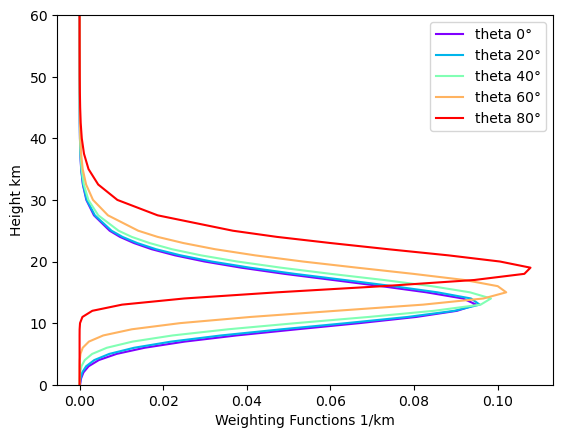

In [3]:
def plot_WF(wf1,Z,lbl):
    import matplotlib.pyplot as plt
    n=np.shape(wf1)[1]
    
    color = iter(plt.cm.rainbow(np.linspace(0, 1, n)))   
    for iv in range(n):
        col=next(color)
        plt.plot(wf1[:,iv]*1000, Z/1000,c=col,label = lbl[iv])
    plt.ylim(0,60)
    plt.legend()    
    
    plt.xlabel('Weighting Functions 1/km')
    plt.ylabel('Height km')
    plt.show()

from load_atm_prf import *
from gas_attenuation_rose98 import *
#profile_file_name='afgl_1986-subarctic_winter.nc'

profile_file_name='./afgl_1986-midlatitude_summer.nc'
# profile_file_name='afgl_1986-tropical.nc'

Z,P,T,RH=load_atm__prf(profile_file_name)
T_surf=T[0]+0  # Surface temperature is taken as equal to the temperature of last layer
T[10]=T[10]+0

Z=Z*1000 # height from km to m

emis=0.7
# frequencies from the satellite radiometer ATMS channels 1-16 
# see https://space.oscar.wmo.int/instruments/view/atms
Frequencies=[  55.5, ]
Obs_angles=[0, 20, 40, 60, 80] # in degrees

#---------------end of settings section ----------------------------------

TB=np.zeros(np.shape(Obs_angles))
wf1=np.zeros((len(Z),len(Obs_angles)))
lbl=[]    
for itheta in range(len(Obs_angles)):
    Obs_angle=Obs_angles[itheta]
    UMU = np.abs(np.cos(Obs_angle*np.pi/180.)  ) # cosine of the Obseration Angle

    T_COS=2.7  # cosmic background radiation temperature
    T_GAL=0.   # Radiation from the galaxy is approximated  to  0
    T_SUN=0.   # Radiation from Sun  approximated  to  0

    T_EXTRA=T_COS + T_GAL + T_SUN

   
    F=Frequencies[0]
    ka=gas_abs(P, T, RH, F)

    gamma = calc_gamma(ka, Z, len(Z), 0,       UMU)

    T_DN = calc_TB_DN(ka,Z,T,UMU)             # TB emitted by the atmosphere downward

    T_SS = (T_EXTRA*gamma + T_DN) *(1-emis) # TB reflected from the surface

    T_SE = emis*T_surf                        # TB emitted from the surface


    T_UP=calc_TB_UP(ka,Z,T,UMU)              # TB emitted by the atmosphere upward

    TB[itheta]=  (T_SS+T_SE)*gamma  + T_UP
    lbl.append('theta ' + str(Obs_angle) +'°')
    for i in range(0,len(Z)):
        wf1[i,itheta]=calc_weighting_function(ka,Z,i,UMU,updir=1)
plot_WF(wf1,Z,lbl)


The Weighting Function Does Change with the observation angle!! At Nadir it peaks (meaning that the higher value of the curve is placed) at lower heights than when observing at 80°. This is a consequence of the sec( $\theta$ ) factor in the clear sky radiative transfer equation.

Now let's move to another set of channesl, we are plotting the Weighting Functions for the Water vapor absorption band at 183 GHz. 



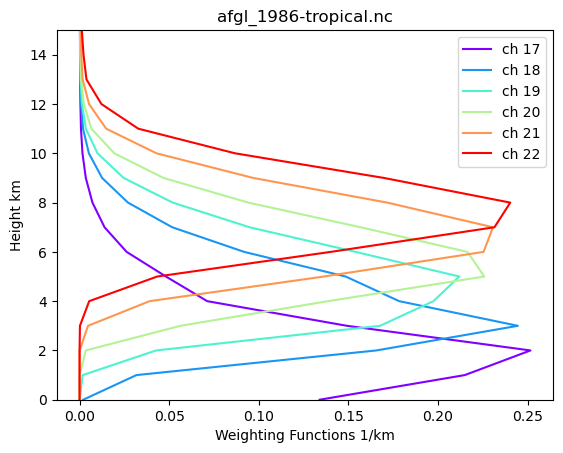

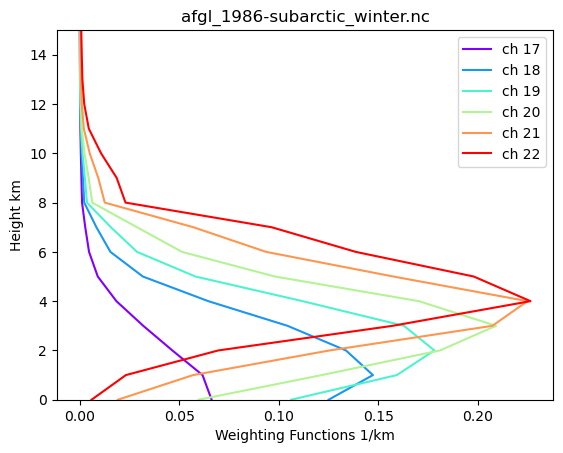

In [4]:
def plot_WF(wf1,Z,lbl,title):
    import matplotlib.pyplot as plt
    n=np.shape(wf1)[1]
    
    color = iter(plt.cm.rainbow(np.linspace(0, 1, n)))   
    for iv in range(n):
        col=next(color)
        plt.plot(wf1[:,iv]*1000, Z/1000,c=col,label = lbl[iv])
    plt.ylim(0,15)
    plt.legend()    
    
    plt.xlabel('Weighting Functions 1/km')
    plt.ylabel('Height km')
    plt.title(title)
    plt.show()
    
    
from load_atm_prf import *
from gas_attenuation_rose98 import *


# profile_file_name='afgl_1986-subarctic_winter.nc'
profile_file_name='afgl_1986-midlatitude_summer.nc'
#profile_file_name='afgl_1986-tropical.nc'
for profile_file_name in ['afgl_1986-tropical.nc','afgl_1986-subarctic_winter.nc']:

    Z,P,T,RH=load_atm__prf(profile_file_name)
    T_surf=T[0]+0  # Surface temperature is taken as equal to the temperature of last layer
    T[10]=T[10]+0

    Z=Z*1000 # height from km to m

    emis=0.7

    Obs_angle=0 # in degrees

    # frequencies from the satellite radiometer ATMS channels 1-16 
    # see https://space.oscar.wmo.int/instruments/view/atms
    Frequencies=[165.6, 
                183.31+7, 
                183.31+4.5, 
                183.31+3, 
                183.31+1.8, 
                183.31+1, ]

    #---------------end of settings section ----------------------------------
    lbl=[]
    UMU = np.abs(np.cos(Obs_angle*np.pi/180.)  ) # cosine of the Obseration Angle

    T_COS=2.7  # cosmic background radiation temperature
    T_GAL=0.   # Radiation from the galaxy is approximated  to  0
    T_SUN=0.   # Radiation from Sun  approximated  to  0

    T_EXTRA=T_COS + T_GAL + T_SUN

    TB=np.zeros(np.shape(Frequencies))
    wf1=np.zeros((len(Z),len(Frequencies)))


    for iv in range(len(Frequencies)):
        F=Frequencies[iv]
        ka=gas_abs(P, T, RH, F)

        gamma = calc_gamma(ka, Z, len(Z), 0,       UMU)

        T_DN = calc_TB_DN(ka,Z,T,UMU)             # TB emitted by the atmosphere downward

        T_SS = (T_EXTRA*gamma + T_DN) *(1-emis) # TB reflected from the surface

        T_SE = emis*T_surf                        # TB emitted from the surface


        T_UP=calc_TB_UP(ka,Z,T,UMU)              # TB emitted by the atmosphere upward

        TB[iv]=  (T_SS+T_SE)*gamma  + T_UP
        lbl.append('ch ' +str(iv+17))
        for i in range(0,len(Z)):
            wf1[i,iv]=calc_weighting_function(ka,Z,i,UMU,updir=1)
    plot_WF(wf1,Z,lbl,profile_file_name)




In this case the differences between two profiles are evident: the tropical profile is very hot (high Temperatures) and Humid, while the subarctic winter profile is very cold and dry. Plese note that in the last case ch 21 Peack is on the Earth surface (the lower level) while the peack of the same channel 17 in the tropical profile is at about 2 km.
